## OralVision

**Note:** In this notebook a lot of code is from the `torchscript` file. It's a pre-written PyTorch code module by our team.

In [1]:
# Some imports.
import torch
from torch import nn
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary

In [2]:
# Device agnostic code.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Current device: {device}")

Current device: cuda


### Setting paths
* Image directory path.
* Testing directory path.
* Training directory path.

In [3]:
from pathlib import Path
image_folder = Path('dental_disease_split_dataset')
print(f"Image folder path: {image_folder}")

Image folder path: dental_disease_split_dataset


In [4]:
train_dir = image_folder / "train"
test_dir = image_folder / "test"
print(f"Train folder path: {train_dir}")
print(f"Test folder path: {test_dir}")

Train folder path: dental_disease_split_dataset\train
Test folder path: dental_disease_split_dataset\test


In [5]:
import os
class_names = os.listdir(train_dir)
class_names

['Caries', 'Gingivitis', 'Hypodontia', 'Mouth_ulcer', 'Tooth_discoloration']

### Visualizing data.
**Writing a resusable function that:**
* Takes the path of train directory or test directory.
* Chooses three random images from any of the randomly chosen classes out of the 5-classes.
* Plots the images, with their class name.

In [6]:
import PIL
import random
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib

def show_random_images(path:pathlib.Path):
    """Shows random images from the train or test directory.
    Args:
        path: pathlib.Path object.
    Returns:
        It returns a matplotlib figure objects with three subplots, random images from the particular directory.
        plt.figure() object."""
    plt.figure(figsize=(12,8))
    img_path_list = list(path.glob('*/*.jpeg'))
    for i in range(3):
        rand_index = random.randint(0, len(img_path_list) - 1)
        random_path = img_path_list[rand_index]
        rand_pil_img = PIL.Image.open(random_path)
        img_array = np.asarray(rand_pil_img)

        plt.subplot(1, 3, i+1)
        plt.imshow(img_array)
        plt.axis(False)
        # Last part of the parent direcotry path as the title.
        plt.title(random_path.parent.stem)

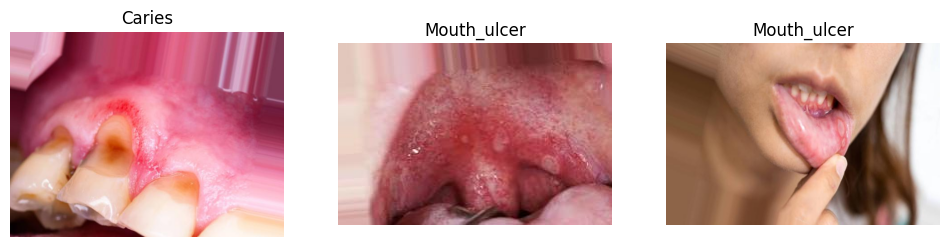

In [7]:
show_random_images(train_dir)

### Creating a transform pipeline that will be used with the tinny vgg model architecture.

In [8]:
# A simple transform for tinny-vgg model.

transform_vgg = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor() 
])

transform_vgg

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

### Creating DataLoaders.
**To create DataLoaders:**
* Using the torchscript custom user defined module for help. 
* Using the datasetup script from this module.


In [9]:
from torchscript import data_setup

# Here V0 stands for version-0.
train_dataloaderV0, test_dataloaderV0, class_namesV0 = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform_vgg, # Because we will use these dataloaders in tiny-vgg model.
    num_workers=0, # Everything on main thread.
    batch_size=32
)

train_dataloaderV0, test_dataloaderV0, class_namesV0

(<torch.utils.data.dataloader.DataLoader at 0x1cb261c2bd0>,
 ['Caries', 'Gingivitis', 'Hypodontia', 'Mouth_ulcer', 'Tooth_discoloration'])

### Creating a model (Tinny-VGG)
* Replicating a model class from cnn-explainer website, called 'Tiny-VGG'.
* It's basically a mini version of the VGG CNN model research paper.

In [11]:
from torchscript import model_builder

# Random seed for reproducibility.
torch.manual_seed(42)
model_tiny = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_namesV0) # Number of categories to classify.
).to(device=device)

print(f"Tiny VGG model description:\n{model_tiny}")

Tiny VGG model description:
TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=5, bias=True)
  )
)


### Training the vgg model.

In [12]:
from torchscript import engine
from timeit import default_timer as time_stamp

# Loss function and optimizer for model_tiny.
loss_fnV0 = nn.CrossEntropyLoss()
optimizerV0 = torch.optim.Adam(params=model_tiny.parameters(), lr=0.001)

start_time_model_tiny = time_stamp()

torch.manual_seed(42)
torch.cuda.manual_seed(42)
results_tiny = engine.train(
    model=model_tiny,
    train_dataloader=train_dataloaderV0,
    test_dataloader=test_dataloaderV0,
    loss_fn=loss_fnV0,
    optimizer=optimizerV0,
    epochs=5, 
    device=device
)

end_time_model_tiny = time_stamp()
total_time_model_tiny = end_time_model_tiny - start_time_model_tiny
print(f"TinyVGG's training time: {total_time_model_tiny} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3836 | train_acc: 0.3836 | test_loss: 1.1414 | test_acc: 0.5297
Epoch: 2 | train_loss: 1.0470 | train_acc: 0.5673 | test_loss: 1.0145 | test_acc: 0.5810
Epoch: 3 | train_loss: 0.9570 | train_acc: 0.6030 | test_loss: 0.9430 | test_acc: 0.6211
Epoch: 4 | train_loss: 0.8886 | train_acc: 0.6363 | test_loss: 0.9186 | test_acc: 0.6285
Epoch: 5 | train_loss: 0.8416 | train_acc: 0.6594 | test_loss: 0.8672 | test_acc: 0.6570
TinyVGG's training time: 87.78690909999989 seconds


### Evaluating tiny-vgg model results.
Using the `plot_loss_curves` function from the `helper_function.py` script.

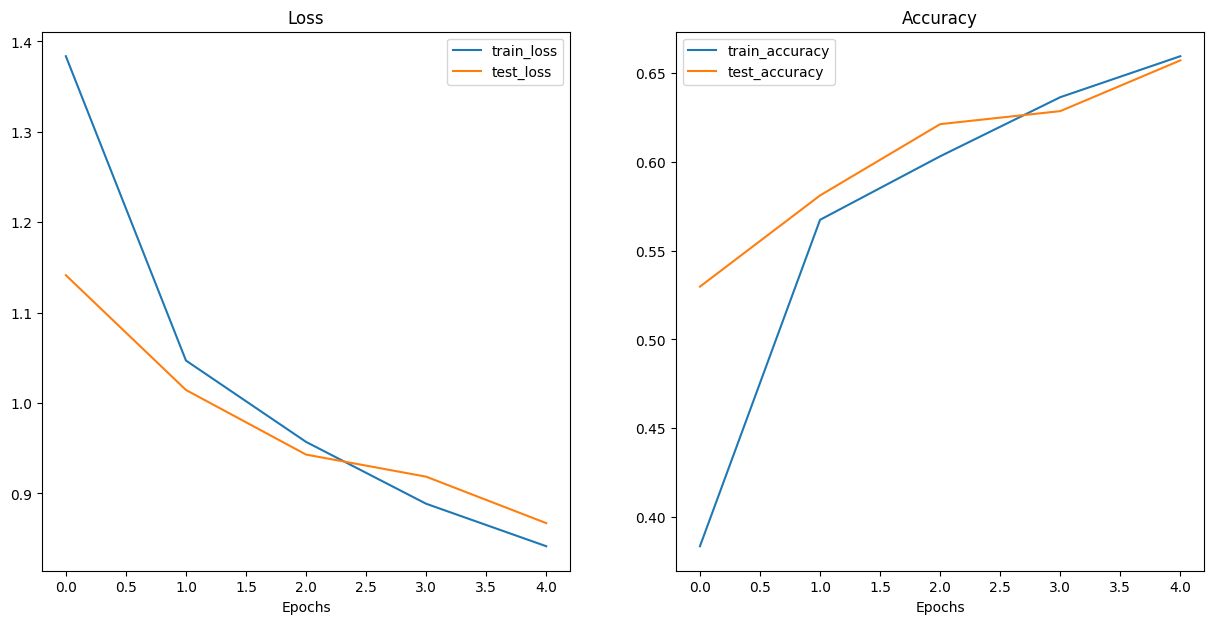

In [13]:
from helper_functions import plot_loss_curves
plot_loss_curves(results=results_tiny)

### Conclusion from tinnyvgg model:
* TinnyVGG model is **not performing that well**.
* The accuracy is around **66 percent**. It's a little better than a **'randomy guessing model'**.
* It's overfitting a little bit. 
* Cosnidering the plot curves it **overfits after the second epoch**.

### Further approach:
* We can use **regularization** using dropout layers and other techniques but it won't be that efficient.
* Because the data is very complex as compared to the model architecture.

**Note about tiny-vgg:**
Tiny-VGG is replicated from **[CNN-Explainer](https://poloclub.github.io/cnn-explainer/)** website. This model is sometimes used to teach students learning Machine Learning and Deep Learning. It's just a mini version of the actual model of the `VGG research` paper.

### Leveraging **Transfer Learning:**
* Trying some pre-trained models, models trained on large datasets, millions of images.
* Using these models for our specific problem.

### Trying EfficientNet (Version - efficientnet_b0)

In [83]:
# Getting weights of pretrained model.
effnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# DEFAULT gives the best performing weights
effnet_weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [84]:
# Transform pipeline used in this model.
effnet_transform = effnet_weights.transforms()
effnet_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [85]:
# Creating model using the weights.
effnet_model = torchvision.models.efficientnet_b0(
    weights=effnet_weights
).to(device=device)

print(f"EfficientNet model description:\n{effnet_model}")

EfficientNet model description:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )


In [ ]:
BATCH_SIZE = 32

train_datav1 = ImageFolder(
    root=train_dir,
    transform=effnet_transform,
    target_transform=None
)

test_datav1 = ImageFolder(
    root=test_dir,
    transform=effnet_transform,
    target_transform=None
)

train_dataloaderV1 = DataLoader(
    dataset=train_datav1,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True,
    pin_memory=True)

test_dataloaderV1 = DataLoader(
    dataset=test_datav1,
    batch_size=BATCH_SIZE,
    num_workers=0,
    shuffle=True,
    pin_memory=True)
class_names = train_datav1.classes

train_dataloaderV1, test_dataloaderV1, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1cb99169010>,
 ['Caries', 'Gingivitis', 'Hypodontia', 'Mouth_ulcer', 'Tooth_discoloration'])

### Summary of effnet_model.

In [87]:
summary(model=effnet_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### Freezing the base layers of effnet_model.

In [88]:
for param in effnet_model.features.parameters():
    param.requires_grad = False

### Summary of effnet_model, after turning of gradient of feature layers.

In [89]:
summary(model=effnet_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Update classifying layer of effnet_model.

In [90]:
effnet_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [91]:
# Updating the classifying layer of the effnet_model.
# Because it classifies 1000 images.
# Our model needs 5.

effnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device=device)

effnet_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)

In [92]:
# Checking the last part of summary, output features.
summary(model=effnet_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 5]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Training the effnet_model.

In [93]:
# Loss function and an optimizer for effnet_model.
loss_fnV1 = nn.CrossEntropyLoss()
optimizerV1 = torch.optim.Adam(
    params=effnet_model.parameters(), lr=0.001
)

loss_fnV1, optimizerV1

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [94]:
from torchscript import engine
from timeit import default_timer as time_stamp

# Set manual seed before training part.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time_effnet = time_stamp()

results_effnet = engine.train(
    model=effnet_model,
    train_dataloader=train_dataloaderV1,
    test_dataloader=test_dataloaderV1,
    optimizer=optimizerV1,
    loss_fn=loss_fnV1,
    epochs=5,
    device=device
)

end_time_effnet = time_stamp()
total_time_effnet = end_time_effnet - start_time_effnet
print(f"Total training time: {total_time_effnet}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7991 | train_acc: 0.7328 | test_loss: 0.5574 | test_acc: 0.8202
Epoch: 2 | train_loss: 0.5282 | train_acc: 0.8197 | test_loss: 0.4402 | test_acc: 0.8627
Epoch: 3 | train_loss: 0.4716 | train_acc: 0.8363 | test_loss: 0.3955 | test_acc: 0.8765
Epoch: 4 | train_loss: 0.4252 | train_acc: 0.8517 | test_loss: 0.3643 | test_acc: 0.8792
Epoch: 5 | train_loss: 0.3982 | train_acc: 0.8658 | test_loss: 0.3486 | test_acc: 0.8885
Total training time: 323.2879793000002


### Evaluating effnet model:

In [95]:
results_effnet

{'train_loss': [0.7991271260589239,
  0.5282178331059193,
  0.47159657734657023,
  0.4251859349968993,
  0.39818939223211],
 'train_acc': [0.7328164805016657,
  0.8196832745443857,
  0.8362789045659416,
  0.8516558886929257,
  0.8658019792279052],
 'test_loss': [0.5573904308271996,
  0.4401865984186714,
  0.3955005806537322,
  0.36428636386070723,
  0.34856445287112836],
 'test_acc': [0.8202160493827161,
  0.8626543209876543,
  0.8765432098765432,
  0.8792438271604939,
  0.8885030864197531]}

In [96]:
import pandas as pd
effnet_results_df = pd.DataFrame(results_effnet)
effnet_results_df

,train_loss,train_acc,test_loss,test_acc
0,0.799127,0.732816,0.557390,0.820216
1,0.528218,0.819683,0.440187,0.862654
2,0.471597,0.836279,0.395501,0.876543
3,0.425186,0.851656,0.364286,0.879244
4,0.398189,0.865802,0.348564,0.888503


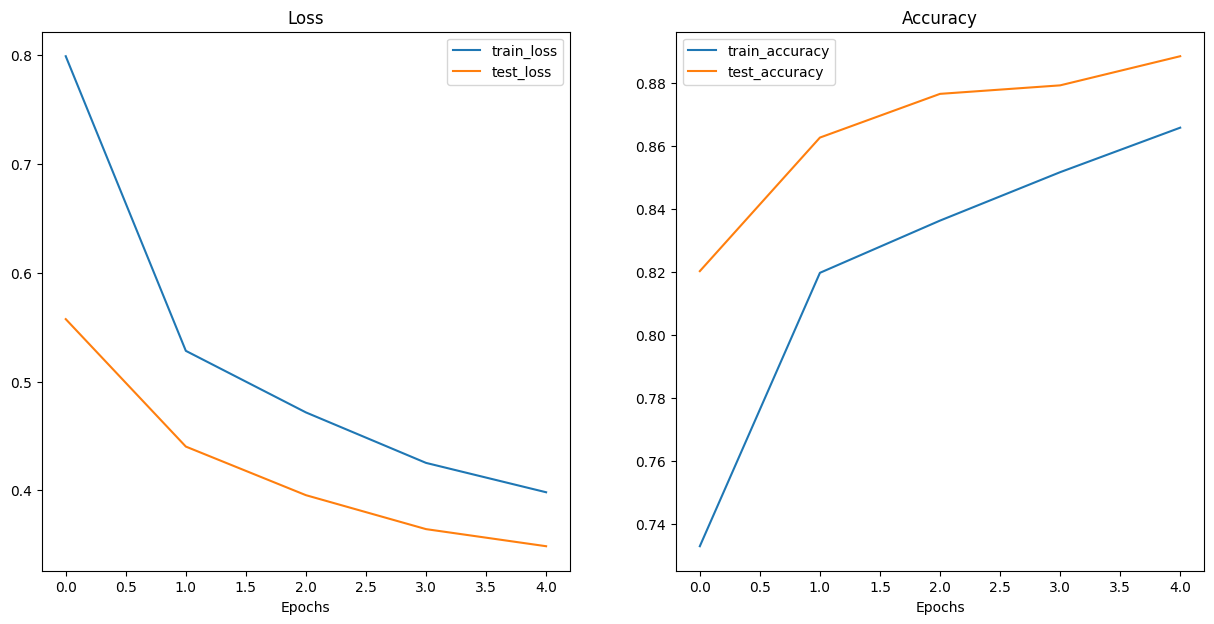

In [97]:
from helper_functions import plot_loss_curves
plot_loss_curves(results_effnet)

### Saving the model dict:
* The results of the effnet model seems quite satisfying.
* We can further fine tune it. But for now its good.
* This model is not **overfitting** and also it is **89 percent** accurate.

In [98]:
effnet_model_savepath = 'models/effnetb0_dict.pth'
torch.save(obj=effnet_model.state_dict(), f=effnet_model_savepath)
print(f"Model's dict has been saved to path: {effnet_model_savepath}")

Model's dict has been saved to path: models/effnetb0_dict.pth


### Loading and testing the effnet_model.

In [99]:
X, y = next(iter(test_dataloaderV1))
X.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [100]:
X[0].shape

torch.Size([3, 224, 224])

In [101]:
from helper_functions import accuracy_fn
from tqdm import tqdm

loaded_effnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
loaded_effnet_model = torchvision.models.efficientnet_b0(
    weights=loaded_effnet_weights
)

# Freezing the bass layers.
for param in loaded_effnet_model.features.parameters():
    param.requires_grad = False

# Update the classifying layer.
loaded_effnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device=device)

# Loading the state dict.
loaded_dict = torch.load(f=effnet_model_savepath, weights_only=True)
loaded_effnet_model.load_state_dict(loaded_dict)
loaded_effnet_model.to(device=device)

# Evaluating the model.
loaded_effnet_model.eval()
with torch.inference_mode():
    test_loss = 0
    test_acc = 0
    for X, y in tqdm(test_dataloaderV1):
        X, y = X.to(device=device), y.to(device=device)
        test_pred = loaded_effnet_model(X)
        loss = loss_fnV1(test_pred, y)
        acc = accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        # Accumulation.
        test_loss += loss
        test_acc += acc

    test_loss /= len(test_dataloaderV1)
    test_acc /= len(test_dataloaderV1)

print(f"Model accuracy: {test_acc}")

100%|██████████| 81/81 [00:15<00:00,  5.14it/s]

Model accuracy: 88.8503086419753


### Creating a function to do predictition and to plot the images.
**What we want in the function:**  
1. The function should take a directory path.
2. The function will also take the trained model as a parameter.
3. Predictions will be done and image will plotted. Prediction prabability and class name will be on the title of image.
4. 

In [102]:
import random
import matplotlib.pyplot as plt
from torch import nn
import torch
from torch.utils.data import DataLoader
from typing import List

def predictions_visuals(model: nn.Module, 
                        dataloader: DataLoader,
                        class_names: List[str],
                        device: torch.device):
    """
    Makes predictions on random unseen images and plots the images with the class names and prediction probabilities.
    If the prediction is correct, it will show the text in class name in green color; otherwise, red.

    Args:
        model: The model we want to make predictions with. It's of type `nn.Module`.
        dataloader: The DataLoader that yields batches of data.
        class_names: List of class names corresponding to model predictions.
        device: The device on which the model and data will be processed.

    Returns:
        It returns a plt.figure object. This figure object will have nine images in a 3x3 grid format with the images and corresponding predicted class names and predicted probabilities.
    """

    plt.figure(figsize=(8, 8))

    # Get the first batch from the dataloader.
    # X stands for features, y stands for labels.
    X, y = next(iter(dataloader))
    for i in range(9):
        index = random.randint(0, len(X) - 1)
        img_tensor = X[index]
        img_class = y[index]

        model.eval()
        with torch.inference_mode():  # Use no_grad for inference
            img_tensor = img_tensor.to(device)
            logits = model(img_tensor.unsqueeze(dim=0))
            pred_prob = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            predicted_class = class_names[pred_label.item()]  # Convert tensor to item

        plt.subplot(3, 3, i + 1)
        image_array = img_tensor.cpu().permute(1, 2, 0).numpy()  # Convert tensor to numpy for imshow
        plt.imshow(image_array)
        plt.axis(False)

        # Check if the prediction matches the actual class
        if predicted_class == class_names[img_class.item()]:  # Ensure img_class is converted to item
            plt.title(f"Class: {predicted_class}\nPred-Prob: {pred_prob.max():.2f}", color='green')
        else:
            plt.title(f"Class: {predicted_class}\nPred-Prob: {pred_prob.max():.2f}", color='red')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


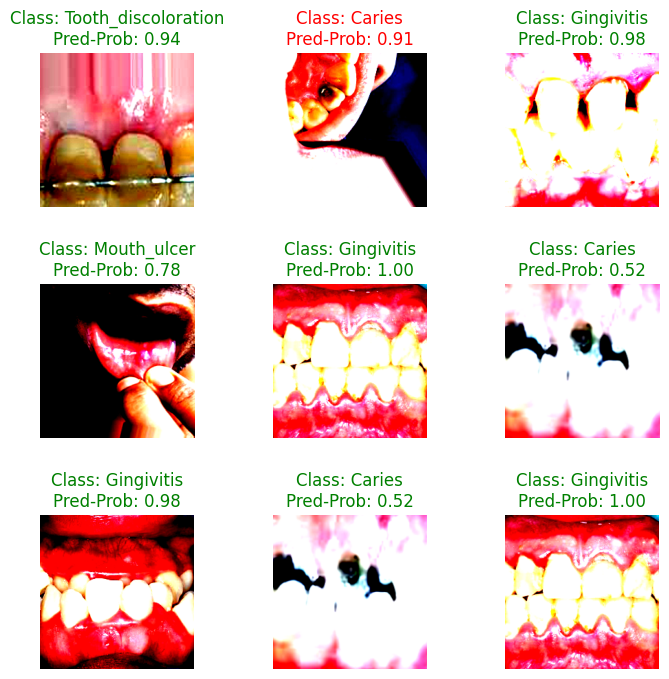

In [103]:
predictions_visuals(
    model=loaded_effnet_model,
    dataloader=test_dataloaderV1,
    class_names=class_names,
    device=device
)

In [104]:
next(iter(train_datav1))[0].shape

torch.Size([3, 224, 224])

### Making a function that can make prediction on a custom image...

In [105]:
import torch
from torch import nn
from pathlib import Path
from PIL import Image
from torchvision import transforms
device="cpu"

def predict_image(model:nn.Module,
                  img_path:str, 
                  model_transform:transforms,
                  device:torch.device=device):
    """A function to make predictions on custom images downloaded from the internet."""
    image_tensor = model_transform(Image.open(img_path))
    image_tensor = image_tensor.unsqueeze(dim=0)
    
    model.to(device=device)
    model.eval()
    with torch.inference_mode():
        logit = model(image_tensor.to(device))
        print(class_names[torch.softmax(logit, dim=1).argmax(dim=1).item()])

In [106]:
predict_image(
    model=loaded_effnet_model,
    img_path='downloads/ulcer_m.jpg',
    model_transform=effnet_transform,
    device=device
)

Mouth_ulcer


### Trying to fine tune effnetb0 model.

In [107]:
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision
from torchinfo import summary
from pathlib import Path

In [108]:
# Device agnostic code
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Current device: {device}")

Current device: cuda


In [109]:
eff2_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
eff2_weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [110]:
eff2_transform = eff2_weights.transforms()
eff2_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [111]:
eff2_model = torchvision.models.efficientnet_b0(weights=eff2_weights).to(device=device)
# Freezing all the base layers
for param in eff2_model.features.parameters():
    param.requires_grad = False

In [112]:
summary(model=eff2_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [113]:
# Unfreezing parameters of the last feature layer
for param in eff2_model.features[-1].parameters():
    param.requires_grad = True

In [114]:
summary(model=eff2_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   Partial
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1,

In [115]:
# Check the classification layer
eff2_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [116]:
# Changing classification layer according to our own problem
eff2_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=5, bias=True)
).to(device=device)

eff2_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=5, bias=True)
)

### Creating data loaders for eff2_model

In [117]:
image_folder = Path("dental_disease_split_dataset")
train_dir = image_folder / "train"
test_dir = image_folder / "test"

train_datav2 = ImageFolder(
    root=train_dir,
    transform=eff2_transform,
    target_transform=None
)

test_datav2 = ImageFolder(
    root=test_dir,
    transform=eff2_transform,
    target_transform=None
)

train_dataloaderV2 = DataLoader(
    dataset=train_datav2,
    batch_size=32,
    num_workers=0,
    shuffle=True,
    pin_memory=True)

test_dataloaderV2 = DataLoader(
    dataset=test_datav2,
    batch_size=32,
    num_workers=0,
    shuffle=False,
    pin_memory=True)
class_names = train_datav2.classes

train_dataloaderV2, test_dataloaderV2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1cb9e958b30>,
 ['Caries', 'Gingivitis', 'Hypodontia', 'Mouth_ulcer', 'Tooth_discoloration'])

### Training the eff2_model

In [118]:
loss_fnV2 = nn.CrossEntropyLoss()
optimizerV2 = torch.optim.Adam(params=eff2_model.parameters(), lr=0.001)

loss_fnV2, optimizerV2

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [119]:
eff2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [120]:
from torchscript import engine
from timeit import default_timer as time_stamp

# Set manual seed before training part.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time_effnet = time_stamp()

results_effnet2 = engine.train(
    model=eff2_model,
    train_dataloader=train_dataloaderV2,
    test_dataloader=test_dataloaderV2,
    loss_fn=loss_fnV2,
    optimizer=optimizerV2,
    epochs=5,
    device=device
)

end_time_effnet = time_stamp()
total_time_effnet = end_time_effnet - start_time_effnet
print(f"Total training time: {total_time_effnet}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5018 | train_acc: 0.8275 | test_loss: 0.2456 | test_acc: 0.9228
Epoch: 2 | train_loss: 0.2068 | train_acc: 0.9322 | test_loss: 0.1630 | test_acc: 0.9487
Epoch: 3 | train_loss: 0.1380 | train_acc: 0.9576 | test_loss: 0.1238 | test_acc: 0.9587
Epoch: 4 | train_loss: 0.0940 | train_acc: 0.9718 | test_loss: 0.1104 | test_acc: 0.9660
Epoch: 5 | train_loss: 0.0772 | train_acc: 0.9761 | test_loss: 0.1014 | test_acc: 0.9660
Total training time: 314.8431711999997


### Evaluate eff2_model

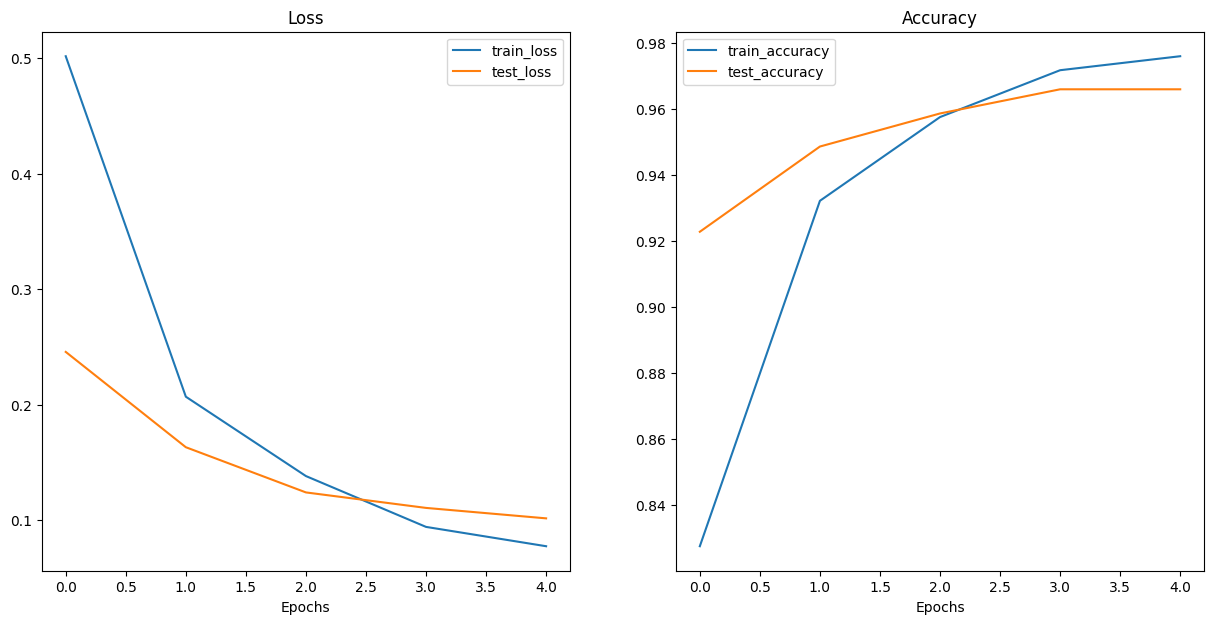

In [121]:
from helper_functions import plot_loss_curves
plot_loss_curves(results_effnet2)

### Conclusion:
* Model overfits a little bit after the second epoch.
* But still it performs very good in the testing set, even after training for 5 epochs.
* It has surpassed the previous model.

### Saving the eff2_model.

In [122]:
eff2_save_path = "models/eff2_model97.pth"
torch.save(obj=eff2_model.state_dict(), f=eff2_save_path)
print(f"Model has been saved!")

Model has been saved!


### Loading this model and testing it like we did with prev model.

In [123]:
from helper_functions import accuracy_fn
from tqdm import tqdm

loaded_eff2_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
loaded_eff2_model = torchvision.models.efficientnet_b0(
    weights=loaded_eff2_weights
).to(device=device)

for param in loaded_eff2_model.features.parameters():
    param.requires_grad = False

for param in loaded_eff2_model.features[-1].parameters():
    param.requires_grad = True

loaded_eff2_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=5, bias=True)
).to(device=device)

loaded_eff2_dict = torch.load(f="models/eff2_model97.pth", weights_only=True)
loaded_eff2_model.load_state_dict(loaded_eff2_dict)

<All keys matched successfully>

In [124]:
# Checking the accuracy of the loaded model
loaded_eff2_model.eval()
with torch.inference_mode():
    test_loss = 0
    test_acc = 0
    for X, y in tqdm(test_dataloaderV2):
        X, y = X.to(device=device), y.to(device=device)
        test_pred = loaded_eff2_model(X)
        loss = loss_fnV2(test_pred, y)
        acc = accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss += loss
        test_acc += acc
    
    test_loss /= len(test_dataloaderV2)
    test_acc /= len(test_dataloaderV2)

print(f"Model accuracy: {test_acc}")

100%|██████████| 81/81 [00:15<00:00,  5.34it/s]

Model accuracy: 96.60493827160494


### Using the function we made to predict and visualize at the same time...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


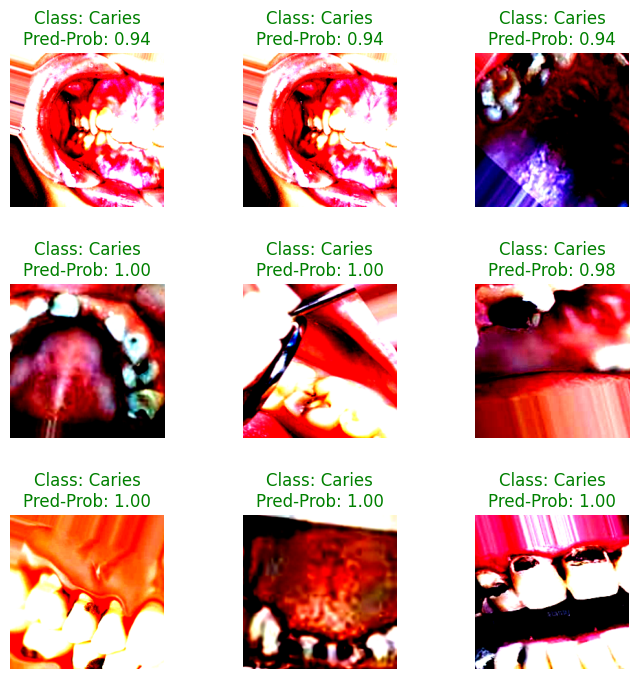

In [125]:
predictions_visuals(
    model=loaded_eff2_model,
    class_names=class_names,
    dataloader=test_dataloaderV2,
    device=device
)

### Creating a function to compare the predictions of both the models...

In [126]:
X, y = next(iter(test_dataloaderV2))
X[0].shape

torch.Size([3, 224, 224])

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from typing import List
import random

def compare_models(
        model1:torch.nn.Module,
        model2:torch.nn.Module,
        dataloader:DataLoader,
        class_names:List[str],
        device:torch.device=device):
    """Compare two models!"""

    model1 = model1.to(device=device)
    model2 = model2.to(device=device)

    X, y = next(iter(dataloader))

    random_tensors = []
    random_tensors_label = []

    for i in range(3):
        index = random.randint(0, len(X)-1)
        random_tensors.append(X[index])
        random_tensors_label.append(y[index])

    # For model-1
    plt.figure(figsize=(8, 4))
    plt.suptitle("Model-1 predictions! Accuracy: 89%")
    model1.eval()
    with torch.inference_mode():
        for i in range(3):
            random_tensors[i] = random_tensors[i].to(device)
            logits = model1(random_tensors[i].unsqueeze(dim=0))
            pred_prob = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            predicted_class = class_names[pred_label.item()]

            plt.subplot(1, 3, i+1)
            plt.imshow(random_tensors[i].cpu().permute(1, 2, 0).numpy())

            if predicted_class == class_names[random_tensors_label[i]]:
                plt.title(f"Class: {predicted_class}\nPred-prob:{pred_prob.max():.2f}", color="green")
            else:
                plt.title(f"Class: {predicted_class}\nPred-prob:{pred_prob.max():.2f}", color="red")

            plt.axis(False)
    plt.subplots_adjust(wspace=0.5, hspace=0.1)

    plt.show()

    # For model-2
    plt.figure(figsize=(8, 4))
    plt.suptitle("Model-2 predictions! Accuracy: 97%")
    model2.eval()
    with torch.inference_mode():
        for i in range(3):
            random_tensors[i] = random_tensors[i].to(device)
            logits = model2(random_tensors[i].unsqueeze(dim=0))
            pred_prob = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            predicted_class = class_names[pred_label.item()]

            plt.subplot(1, 3, i+1)
            plt.imshow(random_tensors[i].cpu().permute(1, 2, 0).numpy())

            if predicted_class == class_names[random_tensors_label[i]]:
                plt.title(f"Class:{predicted_class}\nPred-prob:{pred_prob.max():.2f}", color="green")
            else:
                plt.title(f"Class:{predicted_class}\nPred-prob:{pred_prob.max():.2f}", color="red")
            
            plt.axis(False)
    plt.subplots_adjust(wspace=0.5, hspace=0.1)
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


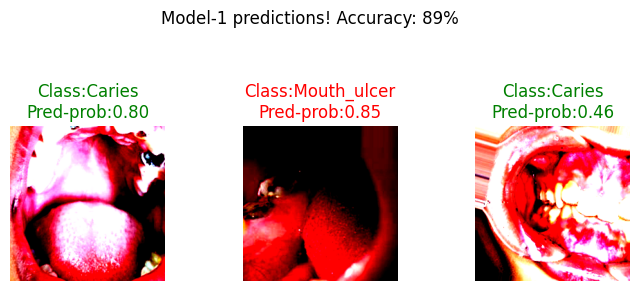

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


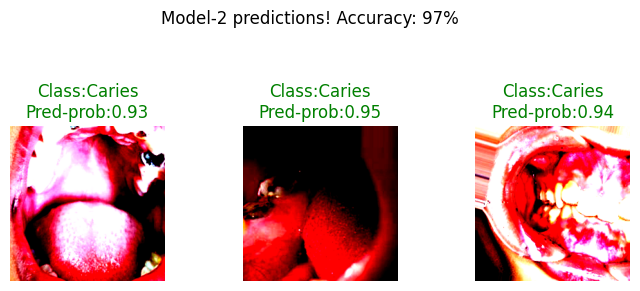

In [175]:
compare_models(model1=loaded_effnet_model, model2=loaded_eff2_model,
               device=device, dataloader=test_dataloaderV2, class_names=class_names)

### Using the prediction function on the new effnet model.

In [176]:
predict_image(model=loaded_eff2_model, img_path='downloads/ging2.jpg',
              model_transform=loaded_eff2_weights.transforms(),device="cuda")

Gingivitis
